In [3]:
%matplotlib inline


In [2]:

import os
import sys
sys.path.append('/root/capsule/aind-beh-ephys-analysis/code/beh_ephys_analysis')

import pandas as pd
import xarray as xr
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps

import json

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re

from utils.beh_functions import session_dirs
from utils.plot_utils import shiftedColorMap, template_reorder, plot_raster_bar,merge_pdfs
from open_ephys.analysis import Session


import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
print(si.__version__)

from scipy import signal
from scipy import stats
from statsmodels.stats.multitest import multipletests

import pickle

from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename

import matplotlib
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from tqdm import tqdm

from aind_ephys_utils import align, sort
from open_ephys.analysis import Session

# import plot_units
# import package_unit_data
from pathlib import Path

import glob
import ast
import scipy.signal as signal

import warnings
warnings.filterwarnings("ignore")

import importlib
from IPython.display import clear_output

print('Finished loading packages')


0.101.2
Finished loading packages


In [4]:
import utils.analysis_funcs as af
import utils.plotting_funcs as pf


In [5]:
# Create a white-to-bright red colormap
colors = [(1, 1, 1), (1, 0, 0)]  # white to red
my_red = LinearSegmentedColormap.from_list("white_to_red", colors)

In [6]:
session = 'behavior_751004_2024-12-20_13-26-11'
session_dir = session_dirs(session)
data_type = 'raw'


resp_thresh = 0.8
lat_thresh = 0.015
pulse_width = 4

In [7]:
sorting = si.load_extractor(session_dir[f'curated_dir_{data_type}'])
unit_ids = sorting.get_unit_ids()

In [7]:
# load quality metrics from nwb
# load quality metrics
if os.path.exists(session_dir[f'nwb_dir_{data_type}']):
    nwb = load_nwb(session_dir[f'nwb_dir_{data_type}'])
    unit_qc = nwb.units[:][['ks_unit_id', 'isi_violations_ratio', 'firing_rate', 'presence_ratio', 'amplitude_cutoff', 'decoder_label']]
else:
    print('No nwb file found.')
#     qm = pd.read_csv(session_dir['qm_dir'], index_col=0)
#     unit_qc = qm[:][['isi_violations_ratio', 'firing_rate', 'presence_ratio', 'amplitude_cutoff']]
#     unit_qc['ks_unit_id'] = unit_qc.index
#     sorting = si.load_extractor(session_dir['curated_dir'])
#     label = sorting.get_property('decoder_label')
#     unit_qc['decoder_label'] = label

pass_qc = (unit_qc['isi_violations_ratio'] < 0.5) & \
          (unit_qc['firing_rate'] > 0.1) & \
          (unit_qc['presence_ratio'] > 0.95) & \
          (unit_qc['amplitude_cutoff'] < 0.05) & \
          (unit_qc['decoder_label'] != 'noise') & \
          (unit_qc['decoder_label'] != 'artifact')
pass_qc = pass_qc.values
pass_qc = {unit_id: pass_qc_curr for unit_id, pass_qc_curr in zip(unit_ids, pass_qc)}
print(f'{sum(pass_qc.values())} out of {len(pass_qc)} units pass quality control')

NameError: name 'unit_ids' is not defined

In [8]:
opto_df = pd.read_csv(os.path.join(session_dir[f'opto_dir_raw'], f'{session}_opto_session.csv'))
with open(os.path.join(session_dir[f'opto_dir_raw'], f'{session}_opto_info.json')) as f:
    opto_info = json.load(f)

In [9]:
with open(os.path.join(session_dir[f'ephys_processed_dir_{data_type}'], 'spiketimes.pkl'), 'rb') as f:
    spiketimes = pickle.load(f)
with open(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_responses_{target}.pkl'), 'rb') as f:
    opto_responses = pickle.load(f)
with open(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_waveforms_{target}.pkl'), 'rb') as f:
    waveforms = pickle.load(f)

# opto_df = pd.read_csv(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_session_{target}.csv'))
# with open(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_info_{target}.json')) as f:
#     opto_info = json.load(f)

NameError: name 'target' is not defined

antidromic latency:  0.015602963839410233
antidromic jitter:  0.016167019927994776


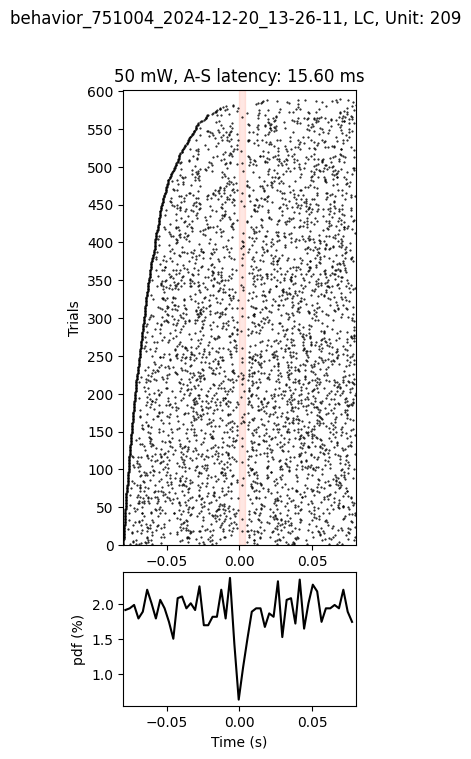

In [17]:
# Plot Antidomic response
def plot_antidromic_response(session_id, unit_id, emission_target):
    ### Plot antidromic unit locations
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.gridspec as gridspec
    import matplotlib.patches as patches

    np.random.seed(0)
    target_unit_id = unit_id
    for ind_unit, ROI_unit in enumerate(target_unit_id):
        # Parameters and settings
        # emission_target = 'PrL'
        # emission_target = 'S1'
        
        # sample_numbers = sorting_output.get_unit_spike_train(ROI_unit)
        unit_spike_times = spiketimes[ROI_unit]
        
        
        trial_type = 'external_red'
        this_emission_location = f'surface_{emission_target}'
        emission_location = f'surface_{emission_target}'
        this_param_group = np.unique(opto_df['param_group'][opto_df['param_group'].str.contains('5Hz', na=False)])[0]

        powers = list(np.unique(opto_df.query('type == @trial_type and emission_location == @emission_location and param_group == @this_param_group').power))            
        max_power = np.max(powers)
        tag_trials = opto_df.query('type == @trial_type and emission_location == @emission_location and param_group == @this_param_group')
        # opto_df[tag_trials.index.tolist()]['time'].values


        
        # this_event_timestamps = laser_onset_times[tag_trials.index.tolist()]
        this_event_timestamps = tag_trials['time'].values


        duration = np.unique(tag_trials.duration)[0]
        num_pulses = np.unique(tag_trials.num_pulses)[0]
        pulse_interval = np.unique(tag_trials.pulse_interval)[0]
        total_duration = (duration * num_pulses) + (pulse_interval * num_pulses)
        raster_time_range = [-total_duration / 1000, (2 * total_duration) / 1000]
        
        event_locked_timestamps = af.event_locked_timestamps(unit_spike_times, this_event_timestamps, raster_time_range)    

        nrow = 4
        gs = gridspec.GridSpec(nrow, 1, width_ratios=[1], height_ratios=[3, 3, 3, 1])

        # Set up the figure
        fig = plt.figure(figsize=(3, 8))
        plt.suptitle(f'{session_id}, {emission_target}, Unit: {ROI_unit}')
        plt.subplots_adjust(hspace=0.4, wspace=0.6)

        # Pulse aligned raster
        gs_inner_pulse_raster = gridspec.GridSpecFromSubplotSpec(nrow, 1, subplot_spec=gs[:, 0], wspace=0.2, hspace=0.2)
        
        for power in [max_power]:    
            duration = np.unique(tag_trials.duration)[0]
            num_pulses = np.unique(tag_trials.num_pulses)[0]
            pulse_interval = np.unique(tag_trials.pulse_interval)[0]
            time_range_raster = [-80/1000, 80/1000]
            
            int_event_locked_timestamps = []
            pulse_nums = []
            
            for pulse_num in range(num_pulses):
                time_shift = pulse_num * (duration + pulse_interval) / 1000
                this_time_range = [time_range_raster[0] + time_shift, time_range_raster[1] + time_shift]
                this_event_locked_timestamps = af.event_locked_timestamps(unit_spike_times, this_event_timestamps, this_time_range, time_shift=time_shift)
                int_event_locked_timestamps.extend(this_event_locked_timestamps)
                pulse_nums.extend([pulse_num + 1] * len(this_event_locked_timestamps))

            
            first_post_stim_spike_times = []
            for a, spike_times in enumerate(int_event_locked_timestamps):
                if spike_times.size > 0 and any(spike_times[spike_times > 0]):       
                    first_post_stim_spike_times.append(spike_times[spike_times > 0][0])
                    # print(first_post_stim_spike_times)
            antidromic_latency = np.median(first_post_stim_spike_times)
            print('antidromic latency: ', antidromic_latency)

            antidromic_jitter = np.std(first_post_stim_spike_times)
            print('antidromic jitter: ', antidromic_jitter)
            
            # collision probability
            antidromic_jitter = 0.005
            # Initialize variables
            trial_num = 0
            collision = []
            data = []
            # Iterate through each trial's spike times            
            for spike_times in int_event_locked_timestamps:
                # collision = 0
                if spike_times.size > 0:
                    collision = 0
                    last_orthodromic_spike_time = []
                    # Find orthodromic and antidromic spike times
                    orthodromic_spike_times = spike_times[spike_times<=antidromic_latency - antidromic_jitter]
                    antidromic_spike_times = spike_times[(antidromic_latency - antidromic_jitter < spike_times) & (spike_times < antidromic_latency + antidromic_jitter)]
                    
                    # print('ortho:', orthodromic_spike_times)
                    # print('anti:', antidromic_spike_times)                                 
                    
                    # Collision determination
                    if orthodromic_spike_times.size > 0:
                        last_orthodromic_spike_time = orthodromic_spike_times[-1]             
                        if antidromic_spike_times.size > 0:
                            collision = 0
                        else:
                            collision = 1
                    else:    
                        last_orthodromic_spike_time = None
                    # Append trial data to list
                    data.append({
                        'trial_num': trial_num,
                        'spike_times': spike_times.tolist(),  # Convert arrays to lists
                        'ortho_spike_times': orthodromic_spike_times.tolist(),  # Convert arrays to lists
                        'last_orthodromic_spike_time': last_orthodromic_spike_time,
                        'anti_spike_times': antidromic_spike_times.tolist(),  # Convert arrays to lists
                        'collision': collision
                    })
                    trial_num += 1

            # collision_prob = np.mean(collision)
            # print(f"Collision probability: {collision_prob:.2f}", f"({np.sum(collision)} out of {trial_num} trials)")
            # collision


            # Plot raster
            ax_pulse_aligned_raster = plt.subplot(gs_inner_pulse_raster[:nrow-1, 0])
            sorted_data = sorted(int_event_locked_timestamps, key=lambda x: (len(x) == 0, x[0] if len(x) > 0 else np.inf))
            pf.raster_plot(sorted_data, time_range_raster)
            # ax_pulse_aligned_raster.plot([antidromic_latency, antidromic_latency], [0, len(sorted_data)], 'r--', linewidth=1)

            # Add a rectangle to indicate laser pulse
            yLims = np.array(plt.ylim())
            laser_color = 'tomato'
            rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0], linewidth=1, edgecolor=laser_color, facecolor=laser_color, alpha=0.15, clip_on=False)
            ax_pulse_aligned_raster.add_patch(rect)
            
            ax_pulse_aligned_raster.set_ylabel('Trials')
            ax_pulse_aligned_raster.set_yticks(np.arange(0, len(sorted_data) + 1, 50))
            ax_pulse_aligned_raster.set_xlim(time_range_raster)
            plt.title(f'{power} mW, A-S latency: {antidromic_latency*1000:.2f} ms')

            # Plot PSTH
            psth, _, bins = pf.psth(int_event_locked_timestamps, time_range_raster, bin_size=0.003, smooth_window_size=3)
            ax_pulse_aligned_psth = plt.subplot(gs_inner_pulse_raster[nrow-1, 0], sharex=ax_pulse_aligned_raster)
            ax_pulse_aligned_psth.plot(bins, psth/sum(psth)*100, color='k')
            ax_pulse_aligned_psth.set_xlabel('Time (s)')
            ax_pulse_aligned_psth.set_ylabel('pdf (%)')

            
            # Create DataFrame from collected data
            antidromic_df = pd.DataFrame(data)     


        # Optional: Save figure (uncomment if needed)
        # fig.savefig(os.path.join(session_dir[f'opto_dir_fig_{data_type}'], f'unit_{unit_id}_pulse_width_{pulse_width}_antidromic.pdf'))

        # fig.savefig(f"{results_folder}/{session_id}_{probe}_Proj2PrL_unit_{ROI_unit}_pulse_aligned_raster.svg", format='svg', dpi=300, bbox_inches='tight')

emission_target = 'LC'
# unit_id = np.arange(32,99).tolist()
unit_id = [209]
plot_antidromic_response(session_id=session, unit_id=unit_id, emission_target=emission_target)


In [93]:
import numpy as np
import pandas as pd

def Avg_y_over_x(x, y, bin_size):
    """
    Compute the average and standard error of y values binned by x.

    Parameters:
    x (array-like): The independent variable values.
    y (array-like): The dependent variable values.
    bin_size (float): The size of the bins for grouping x values.

    Returns:
    pd.DataFrame: A DataFrame with columns for bin centers (x), average y values (y), and standard error of the mean (sem).
    """
    # Calculate bin edges based on the bin size
    edges = np.arange(np.min(x), np.max(x) + bin_size, bin_size)
    
    # Digitize x into bins
    x_index = np.digitize(x, edges) - 1  # Bin indices for each x value
    
    # Calculate bin centers
    bin_centers = (edges[:-1] + edges[1:]) / 2
    
    # Create a DataFrame to store results
    Avg = pd.DataFrame({'x': bin_centers, 'y': np.nan, 'sem': np.nan})

    # Compute mean and standard error for each bin
    for i in range(len(bin_centers)):
        # Mask y values corresponding to the current bin
        bin_y_values = y[x_index == i]
        if bin_y_values.size > 0:
            Avg.at[i, 'y'] = np.nanmean(bin_y_values)
            Avg.at[i, 'sem'] = np.nanstd(bin_y_values) / np.sqrt(bin_y_values.size)

    return Avg, edges


In [94]:
# Plotting for visualization
plt.figure(figsize=(5, 3))
sorted_antidromic_df = antidromic_df.sort_values(by='last_orthodromic_spike_time')
# sorted_antidromic_df['cumsum_success'] = np.cumsum(1-sorted_antidromic_df['collision'])
# last_orthodromic_spike_times = np.sort(antidromic_df['last_orthodromic_spike_time'])
x = (sorted_antidromic_df['last_orthodromic_spike_time'] - antidromic_latency)*1000
y = 1-sorted_antidromic_df['collision']

plt.plot(x, y, 'o-', label='Antidromic spikes', color = [0.8, 0.8, 0.8])
# plt.plot(sorted_antidromic_df['last_orthodromic_spike_time'], sorted_antidromic_df['anti_spike_times'])

# edges = np.arange(-0.1, 0.1, 0.01)
result, edges = Avg_y_over_x(x, y, bin_size = 10)
plt.errorbar(result['x'], result['y'], yerr=result['sem'], fmt='o-', label='Average y with SEM')
plt.xlabel('Time from mean antidromic latency (ms)')
plt.ylabel('P(antidromic spike)')
print(edges)
plt.xlim([-100, 0])
plt.ylim([-0.05, 1.05])

# xlim = [-0.08, 0.0]

NameError: name 'antidromic_df' is not defined

<Figure size 500x300 with 0 Axes>